In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import trange
import tensorflow as tf
from scipy.sparse import csr_matrix

file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep = '\t', names = names)
print('data dimension: \n', data.shape)
data.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [2]:
items_col = 'item_id'
users_col = 'user_id'
ratings_col = 'rating'
threshold = 3

data = data[data[ratings_col] >= threshold]
data[ratings_col] = 1

# binary based on threshold (filter out the zero later
# or else the length won't match)
data[items_col] = data[items_col].astype('category')
data[users_col] = data[users_col].astype('category')
data[ratings_col] = data[ratings_col].astype('category')

ratings = csr_matrix(( data[ratings_col].astype(np.int32),
                       (data[users_col].cat.codes, data[items_col].cat.codes) ))
ratings.eliminate_zeros()
ratings

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 82520 stored elements in Compressed Sparse Row format>

In [3]:
from math import ceil
from scipy.sparse import dok_matrix

def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    TODO: parallelize the computation
    Parameters
    ----------
    ratings : scipy sparse csr_matrix
        The user-item interactions matrix
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    Returns
    -------
    train : scipy sparse csr_matrix
        Training set
    test : scipy sparse csr_matrix
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape, dtype = np.int32)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [4]:
train, test = create_train_test(ratings, test_size = 0.2, seed = 1234)
train

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 65641 stored elements in Compressed Sparse Row format>

In [5]:
class TensorflowBPR:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for the Adam optimizer

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm
        
    n_batch_size : int, default 2000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : boolean, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d numpy array [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d numpy array [n_items, n_factors]
        Item latent factors learnt
        
    item_bias : 1d numpy array [n_items]
        bias term for the items

    history : list
        Loss function's history, can be used to evaluate
        whether the algorithm converged or not

    Reference
    ---------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/pdf/1205.2618.pdf
    """
    def __init__(self, learning_rate = 0.01, n_factors = 15, n_iters = 10, 
                 n_batch_size = 2000, reg = 0.01, seed = 1234, verbose = True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.n_batch_size = n_batch_size
        self.learning_rate = learning_rate
        
    def fit(self, X):
        """
        Parameters
        ----------
        X : scipy sparse csr_matrix [n_users, n_items]
            sparse matrix of user-item interactions
        """
        # history stores the cost, allows assessing convergence
        self.history = []
        indptr = X.indptr
        indices = X.indices
        n_users, n_items = X.shape
        
        # ensure batch size makes sense
        batch_size = self.n_batch_size
        if X.nnz < batch_size:
            batch_size = X.nnz
            sys.stderr.write('WARNING: Batch size is greater than number of training interactions,'
                             'switching to a batch size of {}\n'.format(X.nnz))

        batch_iters = X.nnz // batch_size
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        
        self._build_graph(n_users, n_items)
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)

            for _ in loop:
                iteration_cost = 0.0
                for _ in range(batch_iters):
                    sampled = self._sample(n_users, n_items, indices, indptr)
                    sampled_users, sampled_pos_items, sampled_neg_items = sampled
                    feed_dict = {self._slice_u: sampled_users, 
                                 self._slice_i: sampled_pos_items, 
                                 self._slice_j: sampled_neg_items}
                    _, cost = sess.run([self._train_step, self._total_cost], feed_dict)
                    iteration_cost += cost / self.n_batch_size

                iteration_cost /= batch_iters
                self.history.append(iteration_cost)

            self.user_factors = sess.run(self.user_factors)
            self.item_factors = sess.run(self.item_factors)
            self.item_bias = sess.run(self.item_bias)
        
        return self
        
    def _sample(self, n_users, n_items, indices, indptr):
        """sample batches of random triplets u, i, j"""
        sampled_pos_items = np.zeros(self.n_batch_size, dtype = np.int32)
        sampled_neg_items = np.zeros(self.n_batch_size, dtype = np.int32)
        sampled_users = np.random.choice(n_users, size = self.n_batch_size).astype(np.int32)

        for idx, user in enumerate(sampled_users):
            pos_items = indices[ indptr[user]:indptr[user + 1] ]
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(n_items)
            while neg_item in pos_items:
                neg_item = np.random.choice(n_items)

            sampled_pos_items[idx] = pos_item
            sampled_neg_items[idx] = neg_item

        return sampled_users, sampled_pos_items, sampled_neg_items       
    
    def _build_graph(self, n_users, n_items):
        """build the tensorflow computational graph"""
        # initialize random weights
        self.user_factors = tf.Variable(tf.truncated_normal((n_users, self.n_factors), seed = self.seed), 
                                        name = 'user_factors')
        self.item_factors = tf.Variable(tf.truncated_normal((n_items, self.n_factors), seed = self.seed), 
                                        name = 'item_factors')
        self.item_bias = tf.Variable(tf.zeros(n_items), name = 'item_bias')

        # use tf.gather() to select a non-contiguous slice from the tensor
        # http://stackoverflow.com/questions/35146444/tensorflow-python-accessing-individual-elements-in-a-tensor
        self._slice_u = tf.placeholder(tf.int32, self.n_batch_size)
        self._slice_i = tf.placeholder(tf.int32, self.n_batch_size)
        self._slice_j = tf.placeholder(tf.int32, self.n_batch_size)
        user_u = tf.gather(self.user_factors, self._slice_u)
        item_i = tf.gather(self.item_factors, self._slice_i)
        item_j = tf.gather(self.item_factors, self._slice_j)
        bias_i = tf.gather(self.item_bias, self._slice_i)
        bias_j = tf.gather(self.item_bias, self._slice_j)
        
        # decompose the estimator, compute the difference between
        # the score of the positive items i and negative items j
        x_ui = tf.diag_part( tf.matmul(user_u, tf.transpose(item_i)) )
        x_uj = tf.diag_part( tf.matmul(user_u, tf.transpose(item_j)) )
        x_uij = bias_i - bias_j + x_ui - x_uj

        # minimize the cost
        cost_u = self.reg * tf.reduce_sum(user_u ** 2)
        cost_i = self.reg * tf.reduce_sum(item_i ** 2) + tf.reduce_sum(bias_i ** 2)
        cost_j = self.reg * tf.reduce_sum(item_j ** 2) + tf.reduce_sum(bias_j ** 2)
        cost_uij = tf.reduce_sum( tf.log(tf.nn.sigmoid(x_uij)) )
        self._total_cost = cost_u + cost_i + cost_j - cost_uij
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self._train_step = optimizer.minimize(self._total_cost)
        return self

    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing 
        it every time we call predict, thus there will
        only be an overhead the first time we call it.
        Note, ideally you probably don't need to compute 
        this as it returns a dense matrix and may take
        up huge amounts of memory for large datasets
        """
        if not self._predicted:
            self._get_prediction()
            self._predicted = True

        return self._pred

    def _get_prediction(self):
        """Predicted ratings (dot product of user and item vectors)"""
        self._pred = self.user_factors.dot(self.item_factors.T) + self.item_bias
        return self

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric,
        where we avoid computing the whole predicted rating matrix
        TODO : do we even need this in the class?
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T) + self.item_bias
        return user_pred

In [6]:
bpr_params = {
    'n_factors': 20,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2000 
}

tf_bpr = TensorflowBPR(**bpr_params)
tf_bpr.fit(train)

TensorflowBPR: 100%|██████████| 10/10 [00:30<00:00,  2.93s/it]


In [7]:
from sklearn.metrics import roc_auc_score

def auc_score(model, ratings):
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items, dtype = np.int32)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [8]:
print(auc_score(tf_bpr, train))
print(auc_score(tf_bpr, test))

0.946753849062
0.898517343117


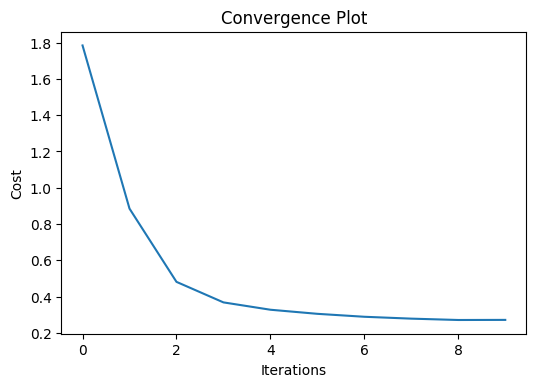

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

plt.plot(tf_bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [10]:
hi

NameError: name 'hi' is not defined

In [ ]:
n_factors = 10
n_users, n_items = train.shape
reg = 0.25
 = 0.05

n_iters = 10
n_batch_size = 2000 # should be smaller than train.nnz

In [ ]:
def generate_boostrapped_samples():
    indices = train.indices
    indptr = train.indptr

    sampled_pos_items = np.zeros(n_batch_size, dtype = np.int32)
    sampled_neg_items = np.zeros(n_batch_size, dtype = np.int32)
    sampled_users = np.random.choice(n_users, size = n_batch_size).astype(np.int32)

    for idx, user in enumerate(sampled_users):
        pos_items = indices[ indptr[user]:indptr[user + 1] ]
        pos_item = np.random.choice(pos_items)
        neg_item = np.random.choice(n_items)
        while neg_item in pos_items:
            neg_item = np.random.choice(n_items)

        sampled_pos_items[idx] = pos_item
        sampled_neg_items[idx] = neg_item
        
    return sampled_users, sampled_pos_items, sampled_neg_items

In [ ]:
#sess = tf.InteractiveSession()

#tf.diag_part(tf.truncated_normal((2, 2)) ** 2).eval()

In [ ]:
seed = 1234
learning_rate = 0.05
n_iters = 10

In [ ]:
#def generate_computational_graph():
user_factors = tf.Variable(tf.truncated_normal((n_users, n_factors), seed = seed), name = 'user_factors')
item_factors = tf.Variable(tf.truncated_normal((n_items, n_factors), seed = seed), name = 'item_factors')
item_bias = tf.Variable(tf.zeros(n_items), name = 'item_bias')

# use tf.gather() to select a non-contiguous slice from the tensor
# http://stackoverflow.com/questions/35146444/tensorflow-python-accessing-individual-elements-in-a-tensor
slice_u = tf.placeholder(tf.int32, n_batch_size)
slice_i = tf.placeholder(tf.int32, n_batch_size)
slice_j = tf.placeholder(tf.int32, n_batch_size)
user_u  = tf.gather(user_factors, slice_u)
item_i  = tf.gather(item_factors, slice_i)
item_j  = tf.gather(item_factors, slice_j)
bias_i  = tf.gather(item_bias, slice_i)
bias_j  = tf.gather(item_bias, slice_j)

#  
x_ui = tf.diag_part( tf.matmul(user_u, tf.transpose(item_i)) )
x_uj = tf.diag_part( tf.matmul(user_u, tf.transpose(item_j)) )
x_uij = bias_i - bias_j + x_ui - x_uj

# minimize the cost
cost_u = reg * tf.reduce_sum(user_u ** 2)
cost_i = reg * tf.reduce_sum(item_i ** 2)
cost_j = reg * tf.reduce_sum(item_j ** 2)
cost_uij = tf.reduce_sum( tf.log(tf.nn.sigmoid(x_uij)) )
total_cost = cost_u + cost_i + cost_j - cost_uij                
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_cost)

In [ ]:
batch_iters = train.nnz // n_batch_size

In [ ]:
history = []

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i in trange(n_iters):
        iteration_cost = 0.0
        for j in range(batch_iters):
            sampled_users, sampled_pos_items, sampled_neg_items = generate_boostrapped_samples()
            feed_dict = {slice_u: sampled_users, slice_i: sampled_pos_items, slice_j: sampled_neg_items}
            _, cost = sess.run([train_step, total_cost], feed_dict)
            iteration_cost += cost / n_batch_size
        
        iteration_cost /= batch_iters
        history.append(iteration_cost)
    
    U = sess.run(user_factors)
    I = sess.run(item_factors)
    B = sess.run(item_bias)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def predict_user(user):
    user_pred = U[user].dot(I.T) + B
    return user_pred

In [ ]:
def auc_score(ratings):
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = predict_user(user)
        y_true = np.zeros(n_items, dtype = np.int32)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [ ]:
print(auc_score(train))
print(auc_score(test))

In [ ]:
class ImplicitMF:
    """
    Alternating Least Squares for implicit feedback

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number/dimension of user and item latent factors

    alpha : int
        scaling factor that indicates the level of confidence in preference

    reg : int
        regularization term for the user and item latent factors

    seed : int
        seed for the randomly initialized user, item latent factors

    Reference
    ---------
    Collaborative Filtering for Implicit Feedback Datasets
    http://yifanhu.net/PUB/cf.pdf
    """
    def __init__(self, n_iters, n_factors, alpha, reg, seed):
        self.reg = reg
        self.seed = seed
        self.alpha = alpha
        self.n_iters = n_iters
        self.n_factors = n_factors
    
    def fit(self, train):
        """train: csr_matrix that holds the training data"""
        
        # the original confidence vectors should include a + 1,
        # but this direct addition is not allowed when using sparse matrix,
        # thus we'll have to deal with this later in the computation
        Cui = self.alpha * train
        Ciu = Cui.T.tocsr()
        self.n_users, self.n_items = Cui.shape
        
        # initialize user latent vectors X and item latent vectors Y
        # randomly with a specified set seed
        rstate = np.random.RandomState(self.seed)
        self.X = rstate.normal( size = (self.n_users, self.n_factors) )
        self.Y = rstate.normal( size = (self.n_items, self.n_factors) )      
        for _ in trange(self.n_iters, desc = 'training progress'):
            self._als_step(Cui, self.X, self.Y)
            self._als_step(Ciu, self.Y, self.X)  
        
        return self
    
    def _als_step(self, Cui, X, Y):
        """
        when solving the user latent vectors,
        the item vectors will be fixed and vice versa
        """
        # the variable name follows the notation when holding
        # the item vector Y constant and solving for user vector X
        
        # YtY is a d * d matrix that is computed
        # independently of each user
        YtY = Y.T.dot(Y)
        data = Cui.data
        indptr, indices = Cui.indptr, Cui.indices

        # for every user build up A and b then solve for Ax = b,
        # this for loop is the bottleneck and can be easily parallized
        # as each users' computation is independent of one another
        for u in range(self.n_users):
            # initialize a new A and b for every user
            b = np.zeros(self.n_factors)
            A = YtY + self.reg * np.eye(self.n_factors)
            
            for index in range( indptr[u], indptr[u + 1] ):         
                # indices[index] stores non-zero positions for a given row
                # data[index] stores corresponding confidence,
                # we also add 1 to the confidence, since we did not 
                # do it in the beginning, when we were to give every 
                # user-item pair and minimal confidence
                i = indices[index]
                confidence = data[index] + 1

                # for b, Y^T C^u p_u
                # there should be a times 1 for the preference 
                # Pui = 1
                # b += confidence * Y[i] * Pui
                # but the times 1 can be dropped
                b += confidence * Y[i]
                
                # for A, Y^T (C^u - I) Y
                A += (confidence - 1) * np.outer(Y[i], Y[i])

            X[u] = np.linalg.solve(A, b)
        
        return self

    def predict(self):
        """predict ratings for every user and item"""
        pred = self.X.dot(self.Y.T)
        return pred
    
    def predict_user(self, user):
        user_pred = self.X[user].dot(self.Y.T)
        return user_pred   

In [ ]:
als = ImplicitMF(n_iters = 20, n_factors = 20, alpha = 15, reg = 0.01, seed = 1234)
als.fit(train)

In [ ]:
def auc_score(model, ratings):
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items, dtype = np.int32)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [ ]:
print(auc_score2(als, train))
print(auc_score2(als, test))

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=50)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
lala

In [ ]:
hi = [1,2,2,4,5]
found = np.searchsorted(hi, 3)
# don't walk off the end of the array
end = len(hi) - 1
if found > end:
    found = end
# hi[found] == 3

In [ ]:
def is_neg_items(pos_items, item):
    position = np.searchsorted(pos_items, item)
    # don't walk off the end of the array
    end = pos_items.shape[0] - 1
    if position > end:
        position = end
    
    return pos_items[position] != item

The AUC specifies the probability that, when we draw two examples at random, their predicted pairwise n_factorsing is correct.

In [ ]:
# user = 0
indices = train.indices
indptr = train.indptr

for user in range(n_users):
    n = 0
    user_auc = 0.0
    predictions = predict_user(user)

    
    # sort the positive items so we can use binary search
    # to determine the negative items later
    pos_items = indices[ indptr[user]:indptr[user + 1] ]
    pos_items = np.sort(pos_items)

    for pos_item in pos_items:
        for neg_item in range(n_items):
            if is_neg_items(pos_items, neg_item):
                n += 1
                if predictions[pos_item] > predictions[neg_item]:
                    user_auc += 1
                    
    user_auc /= n
    auc += user_auc
                
auc / n_users